<a href="https://colab.research.google.com/github/Shabarinath8899/Shabarinath_Chandran_Repository/blob/master/Shabarinath_Chandran_Assignment_3_Street_View_House_Numbers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Street View House Numbers Dataset


The [Street View House Numbers Dataset](https://www.openml.org/d/41081) contains 32-by-32 RGB images centered around a single digit of a house number appearing in Google Street View. Many of the images do contain some distractors at the sides. It consists of 10 classes, 1 for each digit. Digit '1' has label 0, '9' has label 8 and '0' has label 9. Your goal is to build a model that recognizes the correct digit.

In [0]:
%matplotlib inline
!pip install openml
import openml as oml
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pickle
import time

     |████████████████████████████████| 163kB 2.7MB/s 
  Created wheel for openml: filename=openml-0.10.2-cp36-none-any.whl size=190318 sha256=0fb342777772b920b292e304a69b1eaa2be0d8990f02912da55ecb1eda83c87e
  Stored in directory: /root/.cache/pip/wheels/71/ec/5f/aaad9e184680b0b8f1a02ff0ec640cace5adf5bff7bb0af1b4
  Created wheel for liac-arff: filename=liac_arff-2.4.0-cp36-none-any.whl size=13335 sha256=c59d68d4f928ecbff3afc1eb83b353aa54b424482d6686f49d24a595f3c2be07
  Stored in directory: /root/.cache/pip/wheels/d1/6a/e7/529dc54d76ecede4346164a09ae3168df358945612710f5203
Successfully built openml liac-arff


In [0]:
# Download Streetview data. Takes a while to download (5-10 min).
SVHN = oml.datasets.get_dataset(41081)
X, y, cats, attrs = SVHN.get_data(dataset_format='array',
    target=SVHN.default_target_attribute)

In [0]:
# To save time, you can save the dataset to a Google drive, and load it quickly later
from google.colab import drive
drive.mount('/content/drive')

with open("drive/My Drive/SVHN.pkl", "wb") as f:
 pickle.dump(X, f, protocol=pickle.HIGHEST_PROTOCOL)
 pickle.dump(y, f, protocol=pickle.HIGHEST_PROTOCOL)   
 pickle.dump(cats, f, protocol=pickle.HIGHEST_PROTOCOL)
 pickle.dump(attrs, f, protocol=pickle.HIGHEST_PROTOCOL)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# (Uncomment to) Load SVHN dataset from Google drive
from google.colab import drive
drive.mount('/content/drive')

with open("drive/My Drive/SVHN.pkl", "rb") as f:
     X = pickle.load(f)
     y = pickle.load(f)
     cats = pickle.load(f)
     attrs = pickle.load(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### What is the shape of the image data X? How many images are there? Explain why each image has 3072 values.

In [0]:
plot_images
X.shape


(99289, 3072)

* Shape of the image data X is (99289, 3072) and the shape of image is (32*32*3)

* There are 99289 images

* As the dataset contains 32-by-32 RGB images. The value is 32*32 = 1024, multiplied by 3 as RGB contains 3 channels, 
So, 32*32*3 = 3072, Hence the value.


### You can use the following function to plot the first 10 images to get a sense of the data.

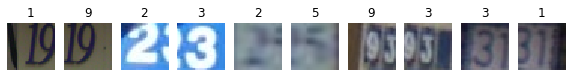

In [0]:
# Plots image. Use grayscale=True for plotting grayscale images
def plot_images(X, y, grayscale=False):
    fig, axes = plt.subplots(1, len(X),  figsize=(10, 5))
    if grayscale:
        [ax.imshow(X[n].reshape(32, 32)/255, cmap='gray')
         for n,ax in enumerate(axes)]
    else:
        [ax.imshow(X[n].reshape(32, 32, 3)/255) for n,ax in enumerate(axes)]
    [ax.set_title((y[n]+1)) for n,ax in enumerate(axes)]
    [ax.axis('off') for ax in axes]
plot_images(X[0:10], y[0:10]);

### Next, we will convert the images to greyscale and normalize the data to fall within the range 0 to 1. Plot the first 10 images to verify that the conversion worked.

In [0]:
def rgb2greyscale(X):
  rgb_weights = [0.2989, 0.5870, 0.1140]
  greyscale_img = np.expand_dims(np.dot((X.reshape(len(X),32*32,3)/255 ),rgb_weights),axis=3)
  return greyscale_img

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


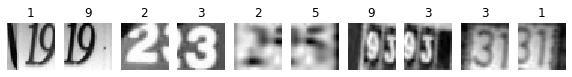

In [0]:
Greyscale = rgb2greyscale(X)
plot_images(Greyscale[0:10],y[0:10],True)

### Evaluate different linear models

1. To save time, use a stratified 1% subsample of the data. Plot the distribution of the classes (as a histogram) for both the original data and the subsample to verify this was done correctly. (hint: a quick way to do it is to borrow the stratify option with sklearn.model_selection.train_test_split)
2. Evaluate k-Nearest Neighbors, Logistic Regression and Linear SVM on this sample, using their default hyperparameter settings. Use cross-validation with 3 folds, output the training accuracy and test accuracy (feel free to reuse code from past assignments). [Time](https://stackoverflow.com/questions/1557571/how-do-i-get-time-of-a-python-programs-execution) how long execution takes.
3. Discuss the results. Are they what you expected? Are the models over/underfitting? What should be done to improve the results?
4. Now evaluate the same models using 3% of the data. Discuss the results. Is the run time what you expect? Which models perform better or worse than the 1% training? How can you explain this in terms of underfitting/overfitting?

1. **To save time, use a stratified 1% subsample of the data. Plot the distribution of the classes (as a histogram) for both the original data and the subsample to verify this was done correctly. (hint: a quick way to do it is to borrow the stratify option with sklearn.model_selection.train_test_split)**

In [0]:
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

# Take a 10% stratified sub sample to speed up experimentation
Sample_X, _, Sample_Y, _ = train_test_split(X,y, stratify=y, train_size=0.01)


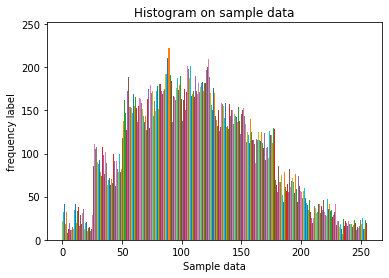

In [0]:
import matplotlib.pyplot as plt 
sample = Sample_X
plt.hist(sample, histtype = 'bar', rwidth = 1) 
  
plt.xlabel('Sample data')  
plt.ylabel('frequency label')  
plt.title('Histogram on sample data') 
plt.show()

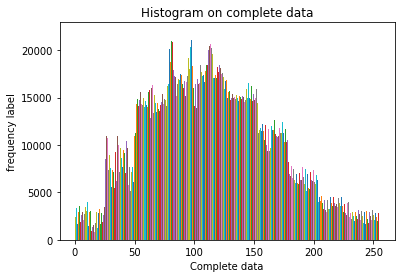

In [0]:

plt.hist(X, histtype = 'bar', rwidth = 1) 
  
plt.xlabel('Complete data')  
plt.ylabel('frequency label')  
plt.title('Histogram on complete data') 
plt.show()

2. **Evaluate k-Nearest Neighbors, Logistic Regression and Linear SVM on this sample, using their default hyperparameter settings. Use cross-validation with 3 folds, output the training accuracy and test accuracy (feel free to reuse code from past assignments). Time how long execution takes.**

In [0]:
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
import sklearn



def evaluate_learners(models, Sample_X, Sample_Y):
    """ Evaluate each model in 'models' with cross-validation on the provided (X, y) data. 
    
    Given a list of models [model1, model2, ..., modelN] return two lists:
     - a list with the scores obtained on the training samples for each model,
     - a list with the test scores obtained on the test samples for each model.
     The order of scores should match the order in which the models were originally provided. E.g.:     
     [Model1 train score, ..., ModelN train score], [Model1 test score, ..., ModelN test score]
    """
    # Evaluate with 5-fold cross-validation.
    xvals = [cross_validate(m, Sample_X, Sample_Y, return_train_score= True, n_jobs=-1) for m in models]
    test_scores = [x['test_score'] for x in xvals]
    train_scores = [x['train_score'] for x in xvals]
    return train_scores, test_scores

In [0]:
models = [ LogisticRegression(), LinearSVC(), KNeighborsClassifier()]
models = np.array([m for m in models]).flatten()
train_scores, test_scores = evaluate_learners(models, Sample_X, Sample_Y)

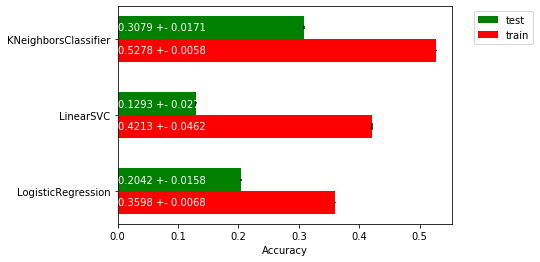

In [66]:
classifiers = [LogisticRegression(), LinearSVC(), KNeighborsClassifier()]
fig, ax = plt.subplots()
width=0.3
ax.barh(np.arange(len(train_scores)), np.mean(test_scores, axis=1), width,
        yerr= np.std(test_scores, axis=1), color='green', label='test')
ax.barh(np.arange(len(train_scores))-width, np.mean(train_scores, axis=1), width,
        yerr= np.std(train_scores, axis=1), color='red', label='train')
for i, te, tr in zip(np.arange(len(train_scores)),test_scores,train_scores):
    ax.text(0, i, "{:.4f} +- {:.4f}".format(np.mean(te),np.std(te)), color='white', va='center')
    ax.text(0, i-width, "{:.4f} +- {:.4f}".format(np.mean(tr),np.std(tr)), color='white', va='center')
ax.set(yticks=np.arange(len(train_scores))-width/2, yticklabels=[c.__class__.__name__ for c in classifiers])
ax.set_xlabel('Accuracy')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2)


plt.show()

In [0]:
import time
start_time = time.time()
evaluate_learners(models, Sample_X, Sample_Y)
print("--- %s seconds ---" % (time.time() - start_time))

--- 115.93540954589844 seconds ---


3. **Discuss the results. Are they what you expected? Are the models over/underfitting? What should be done to improve the results?**

All the models are overfitted as they show good performance with training dataset, but does not perform well with test dataset. Selecting better Hyperparameters could help to improve the models.

4. **Now evaluate the same models using 3% of the data. Discuss the results. Is the run time what you expect? Which models perform better or worse than the 1% training? How can you explain this in terms of underfitting/overfitting?**

In [0]:
Sample_X, _, Sample_Y, _ = train_test_split(X,y, stratify=y, train_size=0.03)

In [0]:
models = [ LogisticRegression(), LinearSVC(), KNeighborsClassifier()]
models = np.array([m for m in models]).flatten()
train_scores, test_scores = evaluate_learners(models, Sample_X, Sample_Y)

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


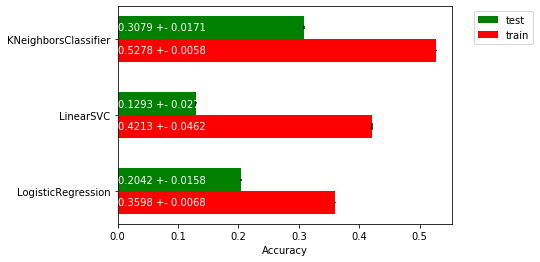

In [67]:
classifiers = [LogisticRegression(), LinearSVC(), KNeighborsClassifier()]
fig, ax = plt.subplots()
width=0.3
ax.barh(np.arange(len(train_scores)), np.mean(test_scores, axis=1), width,
        yerr= np.std(test_scores, axis=1), color='green', label='test')
ax.barh(np.arange(len(train_scores))-width, np.mean(train_scores, axis=1), width,
        yerr= np.std(train_scores, axis=1), color='red', label='train')
for i, te, tr in zip(np.arange(len(train_scores)),test_scores,train_scores):
    ax.text(0, i, "{:.4f} +- {:.4f}".format(np.mean(te),np.std(te)), color='white', va='center')
    ax.text(0, i-width, "{:.4f} +- {:.4f}".format(np.mean(tr),np.std(tr)), color='white', va='center')
ax.set(yticks=np.arange(len(train_scores))-width/2, yticklabels=[c.__class__.__name__ for c in classifiers])
ax.set_xlabel('Accuracy')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2)


plt.show()

In [68]:
import time
start_time = time.time()
evaluate_learners(models, Sample_X, Sample_Y)
print("--- %s seconds ---" % (time.time() - start_time))

/usr/local/lib/python3.6/dist-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


--- 530.6789042949677 seconds ---


All the models are overfitted as they performed well on training data are not as good on test data. Inorder to make them best fit, we need to select hyperparameters properly. 

### Evaluate feed-forward neural network

Counter-intuitively, even though the linear models above are slow, you can easily train the small neural network below with 100% of the data in very little time. Learn more about Google Colab if you're curious: https://research.google.com/colaboratory/faq.html 
1. Train a neural network on the full (100%) data. Start with a single hidden layer with 256 neurons, and the same output layer as this week's Fashion-MNIST lab. Evaluate the accuracy using an 80/20 train test split. How does it compare with the linear models?
2. Plot the confusion matrix. Which digits are often confused with each other? 
3. Plot the first 15 correctly classified examples and the first 15 incorrectly classified examples, along with a bar plot of the predictions array. You can use the provided plotting functions. What sort of errors do you see? Are these indeed 'hard' examples that are easy to get wrong?


1. Train a neural network on the full (100%) data. Start with a single hidden layer with 256 neurons, and the same output layer as this week's Fashion-MNIST lab. Evaluate the accuracy using an 80/20 train test split. How does it compare with the linear models?

In [0]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(predicted_label+1,
                                100*np.max(predictions_array),
                                true_label+1),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, true_label[i]
  plt.grid(False)
  plt.xticks([1,2,3,4,5,6,7,8,9,0],rotation=90)
  plt.yticks([])
  thisplot = plt.bar([1,2,3,4,5,6,7,8,9,0], predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

In [0]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [59]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


In [0]:
X_train, X_test , y_train, y_test = train_test_split(Greyscale.reshape(len(Greyscale),32,32),y,stratify = y,train_size = 0.8)

In [0]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=(32,32)),
    keras.layers.Dense(256,activation = 'relu'),
    keras.layers.Dense(10)
])

In [0]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
             metrics=['accuracy'])

In [63]:
model.fit(X_train, y_train, epochs=10)

Train on 79431 samples
Epoch 1/10
79431/79431 [==============================] - 7s 83us/sample - loss: 2.0241 - accuracy: 0.2735
Epoch 2/10
79431/79431 [==============================] - 6s 76us/sample - loss: 1.6355 - accuracy: 0.4424
Epoch 3/10
79431/79431 [==============================] - 6s 76us/sample - loss: 1.5090 - accuracy: 0.4986
Epoch 4/10
79431/79431 [==============================] - 6s 75us/sample - loss: 1.4504 - accuracy: 0.5251
Epoch 5/10
79431/79431 [==============================] - 6s 76us/sample - loss: 1.4161 - accuracy: 0.5432
Epoch 6/10
79431/79431 [==============================] - 6s 75us/sample - loss: 1.3991 - accuracy: 0.5502
Epoch 7/10
79431/79431 [==============================] - 6s 76us/sample - loss: 1.3837 - accuracy: 0.5565
Epoch 8/10
79431/79431 [==============================] - 6s 76us/sample - loss: 1.3751 - accuracy: 0.5588
Epoch 9/10
79431/79431 [==============================] - 6s 76us/sample - loss: 1.3675 - accuracy: 0.5636
Epoch 10/10
79

In [64]:
test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print('\nTest accuracy:', test_acc)

19858/19858 - 1s - loss: 1.3619 - accuracy: 0.5621

Test accuracy: 0.5621412


The accuracy of 56% is less, hence Neural network is underfitting, it is not performing on both test and training data sets. 

2.Plot the confusion matrix. Which digits are often confused with each other?

In [72]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test ,class_predictions)

array([[2818,  419,   89,  119,   59,  112,   30,    8,   69,   69],
       [ 194, 2325,   56,   46,   34,   54,   70,   16,   85,   67],
       [ 280,  297, 1233,   25,  209,   55,   53,   15,   49,   60],
       [ 251,   89,   33, 1347,   42,  125,    4,   13,   43,   49],
       [ 155,  105,  225,   20, 1056,  137,    9,   15,   93,   38],
       [ 106,   87,   15,  177,  117,  829,    2,   30,   67,  111],
       [ 127,  651,   60,    8,    9,   26,  556,    2,   41,   43],
       [ 148,  125,   42,   53,  214,  375,    5,  201,   94,   84],
       [ 112,  191,   70,   29,   77,  227,   17,    6,  388,  134],
       [ 101,  221,   37,   44,   25,  368,   16,    8,  108,  410]])

In [0]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=90)
    plt.yticks(tick_marks, class_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
class_names = ['0', '1', '2', '3', '4', '5', '6', '7','8', '9']

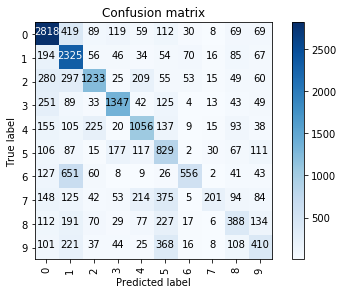

In [75]:
confusion_mtx = confusion_matrix(y_test ,class_predictions)
plot_confusion_matrix(confusion_mtx, class_names)

Which digits are often confused with each other?

6 is misclassified as 1. 3 is misclassified as 0. 1 is misclassified as 0.

3. Plot the first 15 correctly classified examples and the first 15 incorrectly classified examples, along with a bar plot of the predictions array. You can use the provided plotting functions. What sort of errors do you see? Are these indeed 'hard' examples that are easy to get wrong?

In [0]:
probability_model = tf.keras.Sequential([model, 
                                         tf.keras.layers.Softmax()])
class_predictions = model.predict_classes(X_test)
prediction_probabilities = probability_model.predict(X_test)

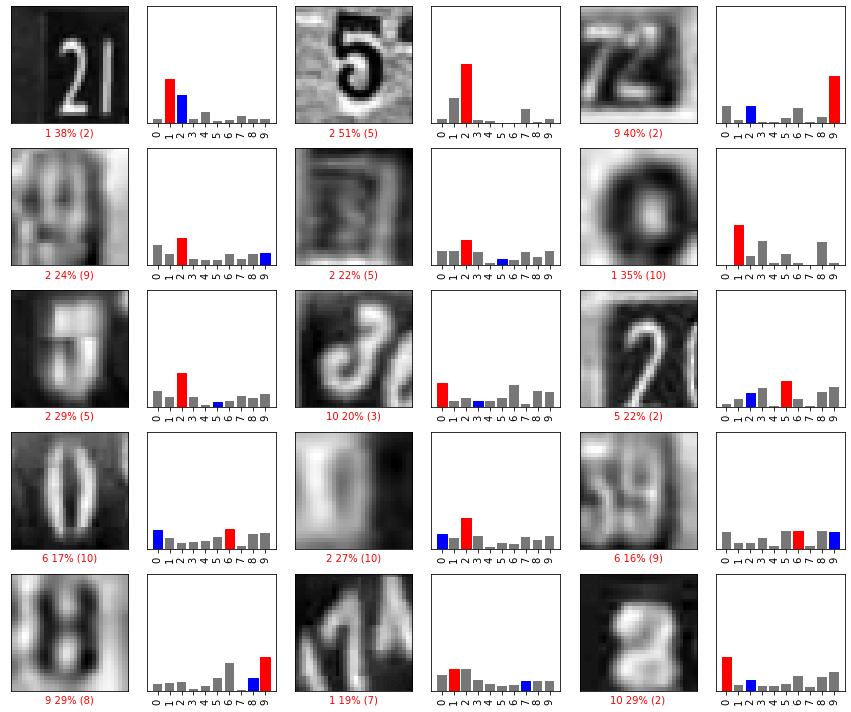

In [70]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
misclassified = np.where(class_predictions != y_test)
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i,j in zip(misclassified[0], range(num_images)):
    plt.subplot(num_rows, 2*num_cols, 2*j+1)
    plot_image(i, prediction_probabilities[i], y_test, X_test)
    plt.subplot(num_rows, 2*num_cols, 2*j+2)
    plot_value_array(i, prediction_probabilities[i], y_test)
plt.tight_layout()
plt.show()

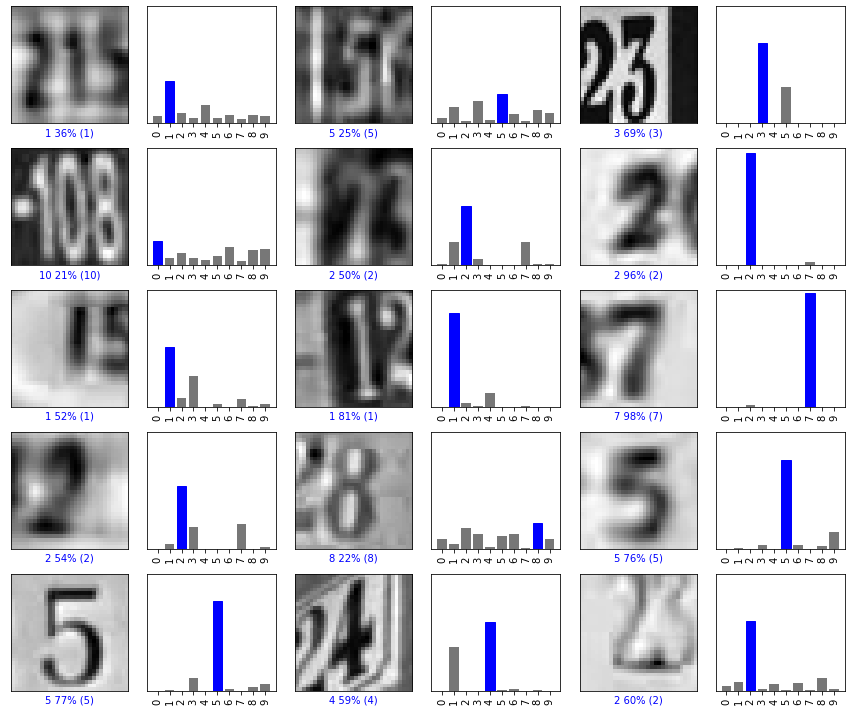

In [71]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
Correctclassified = np.where(class_predictions == y_test)
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i,j in zip(Correctclassified[0], range(num_images)):
    plt.subplot(num_rows, 2*num_cols, 2*j+1)
    plot_image(i, prediction_probabilities[i], y_test, X_test)
    plt.subplot(num_rows, 2*num_cols, 2*j+2)
    plot_value_array(i, prediction_probabilities[i], y_test)
plt.tight_layout()
plt.show()

We could see errors in terms of clarity in numbers. Some of the numbers are blurry and very difficult to read. Yes, seems like these are hard examples that are easy to get wrong.